## 查看小于0的数值

In [ ]:
from RADDet import RADDet, Create_RADDet_Pretrain_Dataset
import torch
import data_utils as du

config_path = '/mnt/SrvUserDisk/ZhangXu/pretrain/rpt/datasets/RADDet_config.json'
dataset_train = Create_RADDet_Pretrain_Dataset(config_path)
# data_loader_train = torch.utils.data.DataLoader(
#     dataset_train,
#     sampler = torch.utils.data.RandomSampler(dataset_train),
#     batch_size=4,
#     num_workers=20,
#     pin_memory=True,
#     drop_last=False,
# )
print(len(dataset_train))
for i in range(len(dataset_train)):
    if i > 3:
        break
    filename, data = dataset_train[i]
    negative_matrix = (data < 0).float()
    positive_matrix = (data > 0).float()



    print(filename)
    print(f'负值比例为：{negative_matrix.mean()}')
    print(f'负值均值为{(data * negative_matrix).sum() / (negative_matrix.sum())}')
    print(f'正值均值为{(data * positive_matrix).sum() / (positive_matrix.sum())}')

    du.plot_RAD(negative_matrix.cpu().numpy())
# for i, data in enumerate(data_loader_train):
#     # print(i, data)
#     print(i, data.shape)

## 查看功率高的前10%的点

In [ ]:
import torch
def get_top_data(data, keep_ratio=0.1):
    '''保留data前keep_ratio%功率的点'''
    magnitude = torch.abs(data)

    # 计算保留的阈值，按keep_ratio选择前部分
    # quantile : 数据从小到大排序，然后取百分位置的值，就是第几个分位数，0.5就是中位数，不是整数会计算索引对应数值的均值
    threshold = torch.quantile(magnitude.flatten(), 1 - keep_ratio)

    retain_data = data.clone()
    # 将幅值低于阈值的部分设为0，保留幅值前keep_ratio的点
    retain_data[magnitude < threshold] = 0

    return retain_data



In [ ]:
from RADDet import RADDet, Create_RADDet_Pretrain_Dataset
import data_utils as du

config_path = '/mnt/SrvUserDisk/ZhangXu/pretrain/rpt/datasets/RADDet_config.json'
dataset_train = Create_RADDet_Pretrain_Dataset(config_path)
print(len(dataset_train))

for i in range(len(dataset_train)):
    if i > 3:
        break
    filename, data = dataset_train[i]
    retain_data = get_top_data(data, 0.005)


    print(filename)

    print(f'remove ratio: {(retain_data == 0).float().mean()}')

    du.plot_RAD(data.cpu().numpy())
    du.plot_RAD(retain_data.cpu().numpy())

## test data_loading time

In [ ]:
import json
import os
import glob
import numpy as np
import time
config_path = '/mnt/SrvUserDisk/ZhangXu/pretrain/rpt/datasets/RADDet_config.json'
with open(config_path) as json_file:
    config = json.load(json_file)

config_data = config["DATA"]

sequences_train = glob.glob(os.path.join(config_data["train_set_dir"], "RAD/*/*.npy"))
sequences_test = glob.glob(os.path.join(config_data["test_set_dir"], "RAD/*/*.npy"))
RAD_data = []
sequences = sequences_train
for i in range(len(sequences)):
    start_time = time.time()
    RAD_filename = sequences[i]
    RAD_data.append(np.load(RAD_filename))
    print(f"load time: {time.time() - start_time:.2f}s")

多线程测试

In [ ]:
import json
import os
import glob
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# 加载配置文件
config_path = '/mnt/SrvUserDisk/ZhangXu/pretrain/rpt/datasets/RADDet_config.json'
with open(config_path) as json_file:
    config = json.load(json_file)

config_data = config["DATA"]
sequences_train = glob.glob(os.path.join(config_data["train_set_dir"], "RAD/*/*.npy"))
sequences_test = glob.glob(os.path.join(config_data["test_set_dir"], "RAD/*/*.npy"))

sequences = sequences_train  # 选择使用训练数据集
RAD_data = []

# 定义加载函数
def load_data(filename):
    start_time = time.time()
    data = np.load(filename)
    print(f"{filename} load time: {time.time() - start_time:.2f}s")
    return data

# 设置多线程加载
max_workers = 2
with ThreadPoolExecutor(max_workers=max_workers) as executor:  # max_workers 设置线程数
    future_to_filename = {executor.submit(load_data, seq): seq for seq in sequences}
    
    for future in as_completed(future_to_filename):
        RAD_data.append(future.result())
        filename = future_to_filename[future]
        # print(f"{filename} load time: {time.time() - start_time:.2f}s")

# print(f"Total load time: {time.time() - start_time:.2f}s")


## Calculating the mean and std of the dataset

In [ ]:
import json
import os
import glob
import numpy as np
import time
import concurrent.futures
from tqdm import tqdm

# data_type = 'CARRADA'  
data_type = 'RADDet'
if data_type == 'CARRADA':
    data_dir = '/mnt/SrvDataDisk/Datasets_Radar/CARRADA'
    sequences_all = glob.glob(os.path.join('/mnt/SrvDataDisk/Datasets_Radar/CARRADA/Carrada_RAD', "*/*/*.npy"))
elif data_type == 'RADDet':
    data_dir = '/mnt/Disk/zx/data/RADDet_author'
    sequences_train = glob.glob(os.path.join(data_dir, "train", "RAD/*/*.npy"))
    sequences_test = glob.glob(os.path.join(data_dir, "test", "RAD/*/*.npy"))
    sequences_all = sequences_train + sequences_test
# sequences_all.sort()



print(len(sequences_all))

# 用于存储全局的累积值
global_sum_log = 0
global_sum_square_log = 0
global_min_log = float('inf')
global_max_log = -float('inf')
total_count = 0

# 计算每个文件的日志指标
def process_file(file_path):
    data = np.load(file_path)
    log_data = np.log(np.abs(data) + 1e-10)  # 避免 log(0)
    mean_log = np.mean(log_data)
    max_log = np.max(log_data)
    min_log = np.min(log_data)
    variance_log = np.var(log_data)
    count = log_data.size
    return mean_log, max_log, min_log, variance_log, count

# 使用多线程处理所有文件并添加进度条
start_time = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:  # 设定线程数
    results = []
    for result in tqdm(executor.map(process_file, sequences_all), total=len(sequences_all)):
        results.append(result)

# 累积全局指标
for mean_log, max_log, min_log, variance_log, count in results:
    global_sum_log += mean_log * count
    global_sum_square_log += (variance_log + mean_log**2) * count
    global_min_log = min(global_min_log, min_log)
    global_max_log = max(global_max_log, max_log)
    total_count += count

# 计算全局指标
global_mean_log = global_sum_log / total_count
global_variance_log = (global_sum_square_log / total_count) - (global_mean_log ** 2)

print("Time used:", time.time() - start_time)
# 打印结果
print("Global Mean Log:", global_mean_log)
print("Global Max Log:", global_max_log)
print("Global Min Log:", global_min_log)
print("Global Variance Log:", global_variance_log)

应该是先算完再做个log吧

In [ ]:
import os
import glob
import numpy as np
import torch
from tqdm import tqdm

data_type = 'CARRADA'  
# data_type = 'RADDet'

if data_type == 'CARRADA':
    data_dir = '/mnt/SrvDataDisk/Datasets_Radar/CARRADA'
    sequences_all = glob.glob(os.path.join(data_dir, "Carrada_RAD", "*/*/*.npy"))
elif data_type == 'RADDet':
    data_dir = '/mnt/Disk/zx/data/RADDet_author'
    sequences_train = glob.glob(os.path.join(data_dir, "train", "RAD/*/*.npy"))
    sequences_test = glob.glob(os.path.join(data_dir, "test", "RAD/*/*.npy"))
    sequences_all = sequences_train + sequences_test

# Initialize variables to accumulate statistics
sum_val = 0.0
sum_square = 0.0
min_val = float('inf')
max_val = float('-inf')
total_count = 0

# Process each file
for file_path in tqdm(sequences_all):
    data = np.load(file_path)
    data_tensor = torch.tensor(data, dtype=torch.float32).cuda()  # Load data to GPU

    # Update statistics
    sum_val += torch.sum(data_tensor).item()
    sum_square += torch.sum(data_tensor ** 2).item()
    min_val = min(min_val, torch.min(data_tensor).item())
    max_val = max(max_val, torch.max(data_tensor).item())
    total_count += data_tensor.numel()

# Compute mean and std deviation
mean_val = sum_val / total_count
# 平方的均值减均值的平方->方差
std_val = (sum_square / total_count - mean_val ** 2) ** 0.5

print("Mean:", mean_val)
print("Standard Deviation:", std_val)
print("Minimum:", min_val)
print("Maximum:", max_val)


In [ ]:
np.log(201)




    

## use PCA to reduce the dimension of the data

In [5]:
import json
import os
import glob
import numpy as np
import time
import concurrent.futures
from tqdm import tqdm

# data_type = 'CARRADA'  
data_type = 'RADDet'
RADDet_ADC = True
if data_type == 'CARRADA':
    # data_dir = '/mnt/SrvDataDisk/Datasets_Radar/CARRADA/Carrada_RAD/'
    data_dir = '/mnt/SrvDataDisk/Datasets_Radar/CARRADA/Carrada/data'
    sequences_all = glob.glob(os.path.join(data_dir, "*/range_doppler_raw/*.npy"))

    RAD_data_dir = '/mnt/SrvDataDisk/Datasets_Radar/CARRADA'
    RAD_sequences_all = glob.glob(os.path.join(RAD_data_dir, "Carrada_RAD", "*/*/*.npy"))
elif data_type == 'RADDet':
    if RADDet_ADC:
        data_dir = '/mnt/SrvDataDisk/Datasets_Radar/RADDet/RADDet_author/ADC'
        sequences_all = glob.glob(os.path.join(data_dir, "*.npy"))
    else:
        data_dir = '/mnt/SrvDataDisk/Datasets_Radar/RADDet/RADDet_reprocessed_by_ljm'
        sequences_train = glob.glob(os.path.join(data_dir, "train", "RD/*/*.npy"))
        sequences_test = glob.glob(os.path.join(data_dir, "test", "RD/*/*.npy"))
        sequences_all = sequences_train + sequences_test


    RAD_data_dir = '/mnt/Disk/zx/data/RADDet_author'
    RAD_sequences_train = glob.glob(os.path.join(RAD_data_dir, "train", "RAD/*/*.npy"))
    RAD_sequences_test = glob.glob(os.path.join(RAD_data_dir, "test", "RAD/*/*.npy"))
    RAD_sequences_all = RAD_sequences_train + RAD_sequences_test
    mean_log = 3.243985
    std_log = 0.643747



sequences_all.sort()
# RAD_sequences_all.sort()
print(len(sequences_all))
print(len(RAD_sequences_all))



10158
10158


In [ ]:
# import data_utils as du
# import lexcube

# for index in range(len(sequences_all)):
#     if index > 1:
#         break
#     ADC_data = du.readRAD(sequences_all[index])     # (256, 64, 4, 2)
#     ADC_data = ADC_data.reshape(256, 64, 8)

#     # ADC_padded_data = np.concatenate([ADC_data, np.zeros((ADC_data.shape[0], ADC_data.shape[1], 256-8))], axis=-1)

#     R_FFT_data = np.fft.fft(ADC_data, n=256, axis=0)
#     RD_FFT_data = np.fft.fft(R_FFT_data, n=64, axis=1)

#     RD_FFT_data_padded = np.concatenate([RD_FFT_data, np.zeros((RD_FFT_data.shape[0], RD_FFT_data.shape[1], 256-8))], axis=-1)
#     RAD_FFT_data = np.fft.fft(RD_FFT_data, n=256, axis=-1)

#     RAD_data = du.readRAD(RAD_sequences_all[index]).transpose(0, 2, 1)
#     # du.plot_RAD(RAD_data)

#     # print(np.allclose(RAD_data, FFT_IFFT_RAD_data, atol=1e-6))
#     print(np.allclose(RAD_data, RAD_FFT_data, atol=1e-6))
#     # print(np.equal(RAD_data, FFT_IFFT_RAD_data))
#     # print(np.equal(RAD_data, FFT_data))
    

Reconstruction error: 0.006670971401035786
False


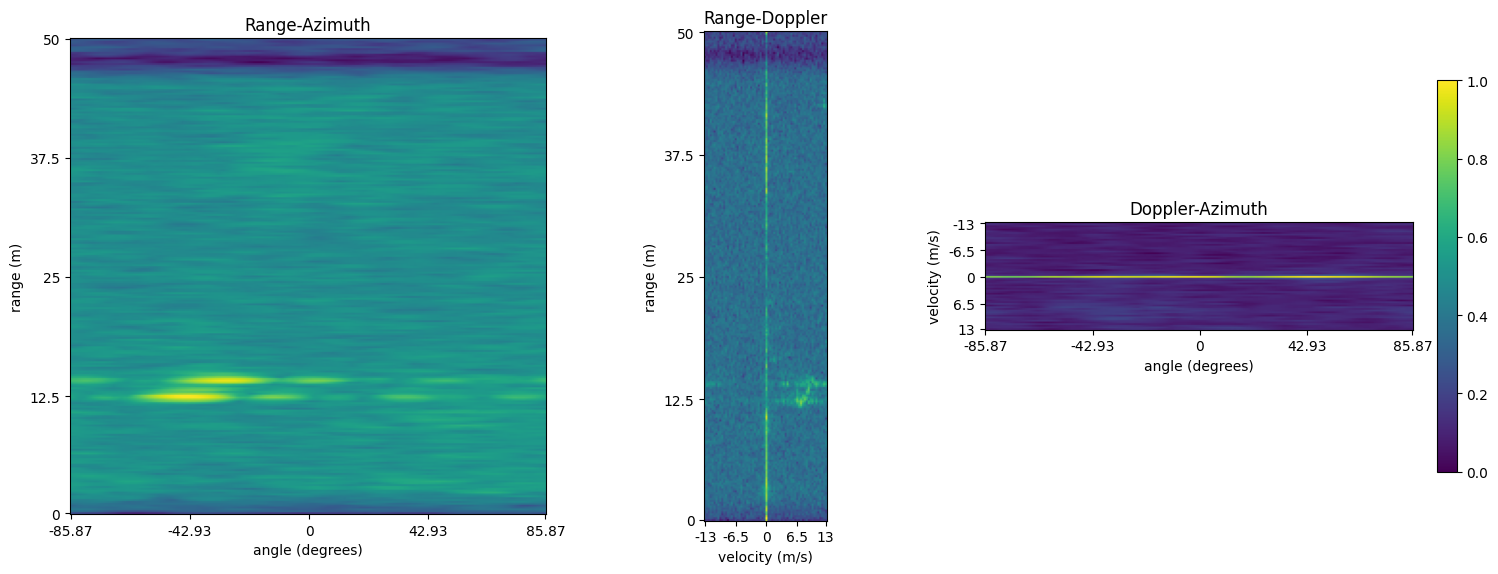

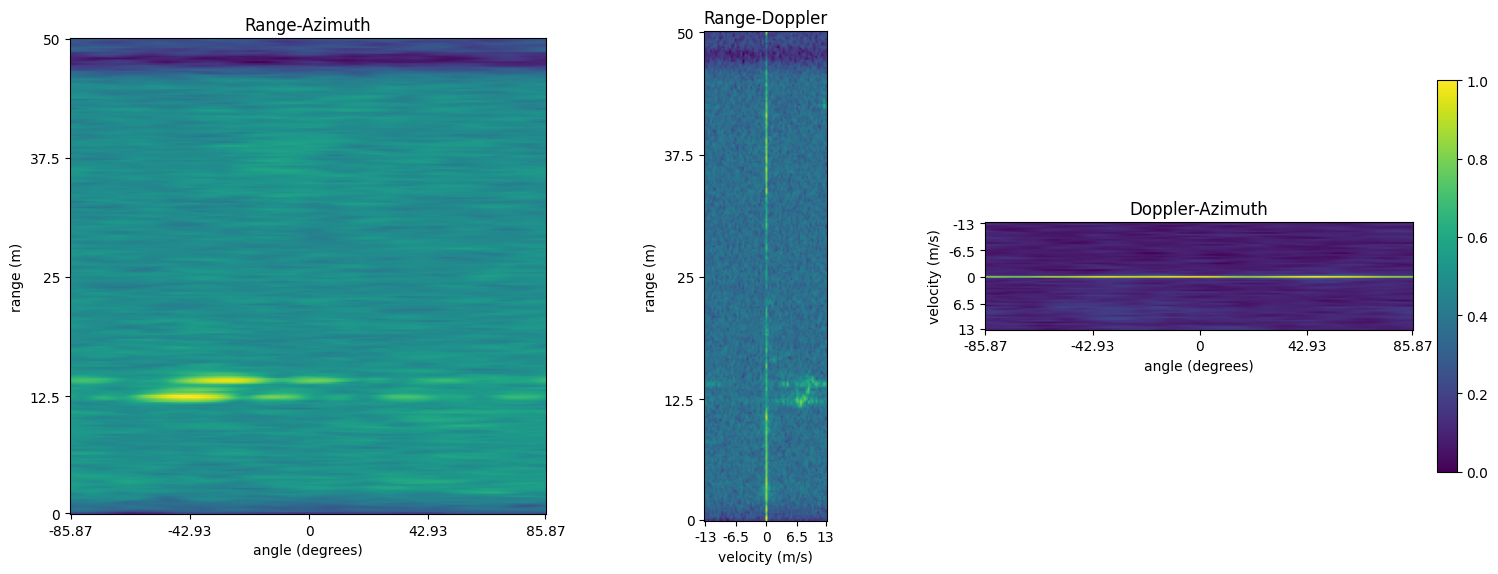

Reconstruction error: 0.005219446960836649
False


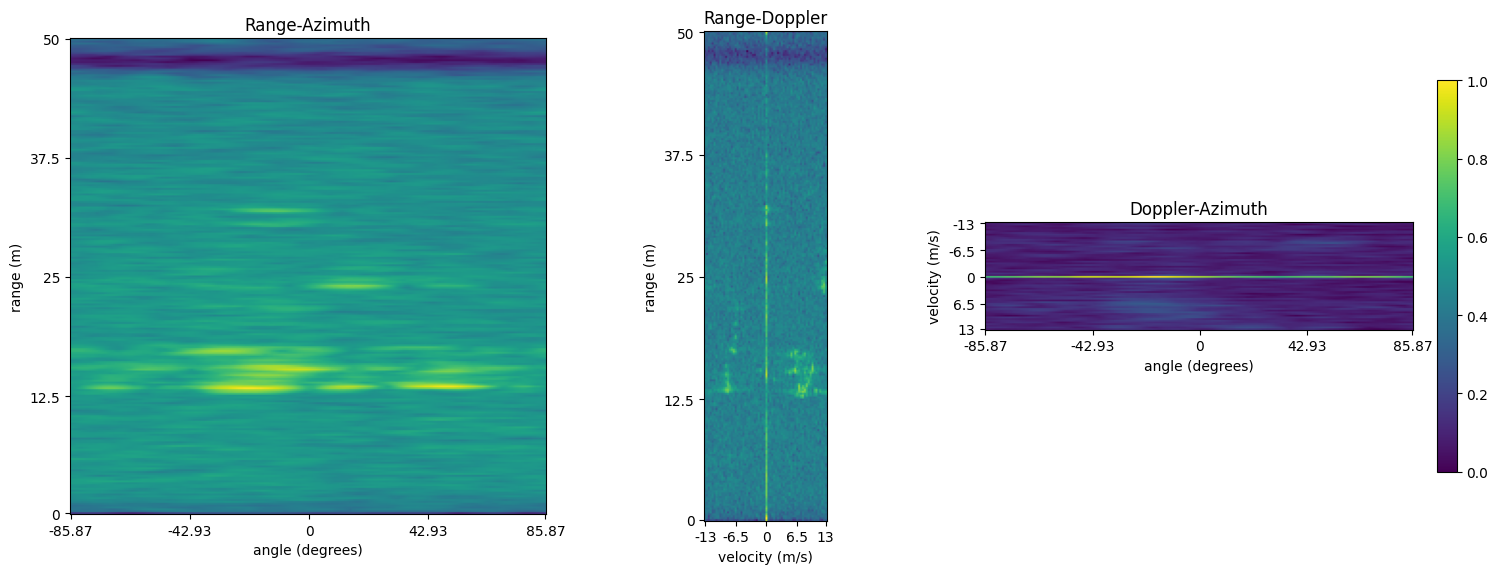

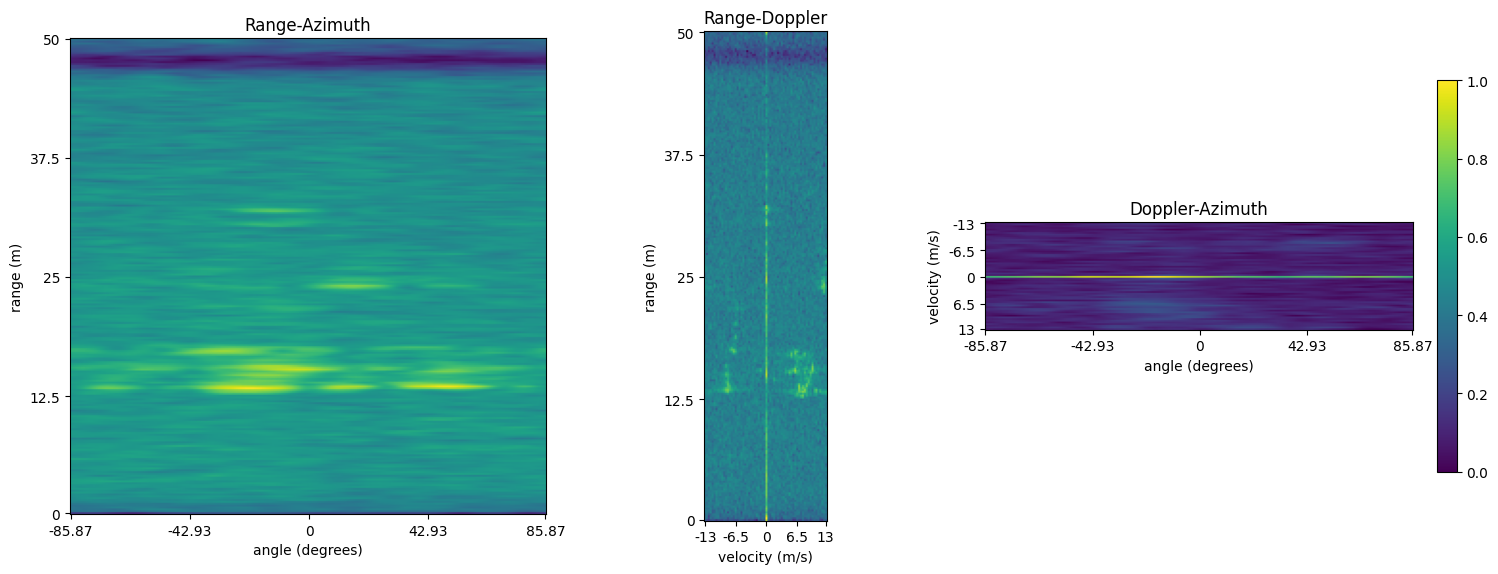

Reconstruction error: 0.00550687313079834
False


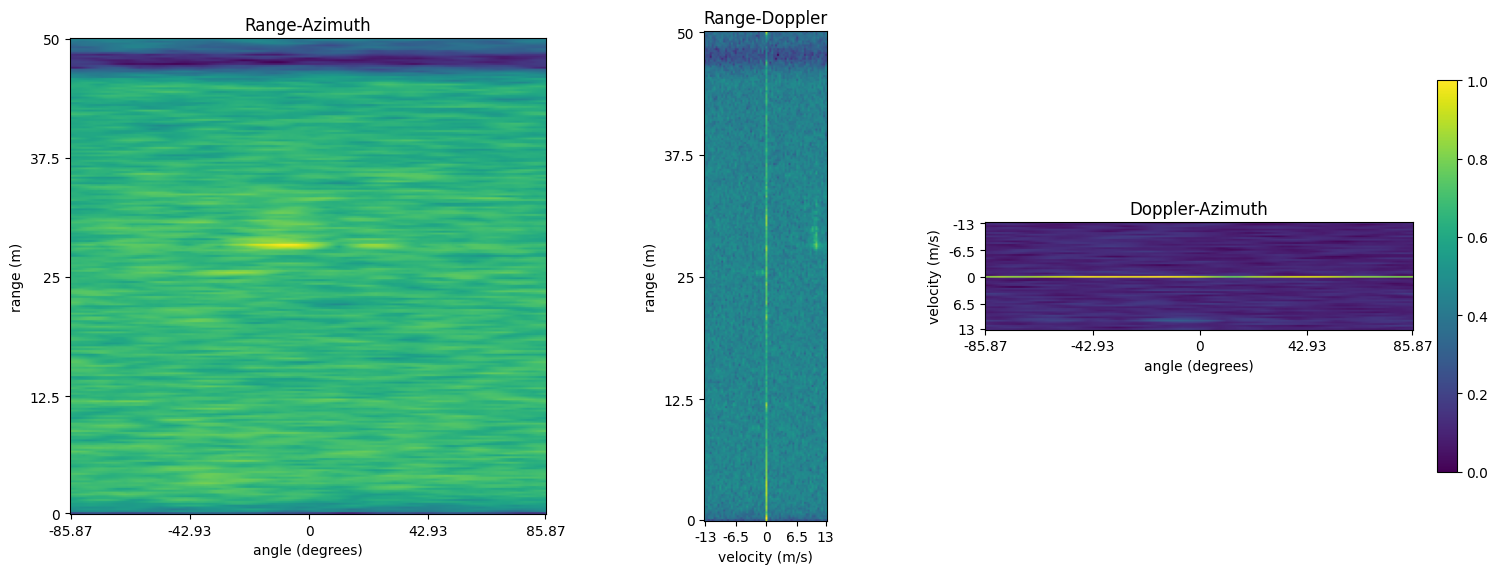

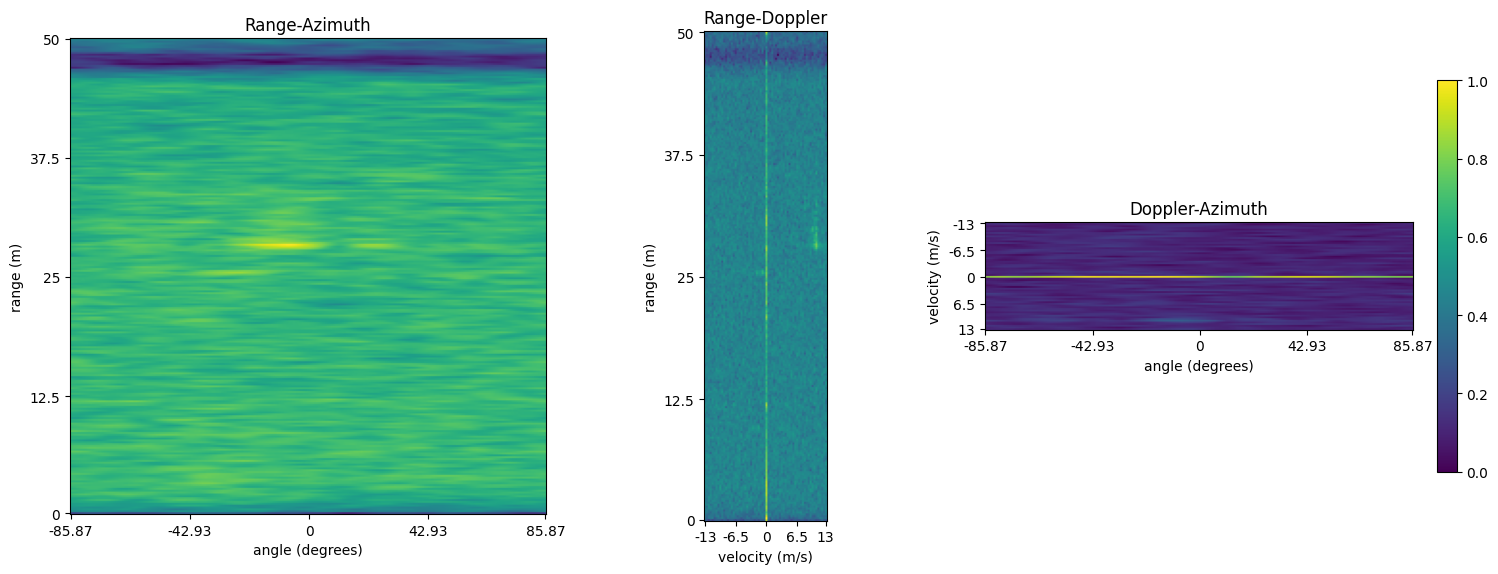

Reconstruction error: 0.00486065773293376
False


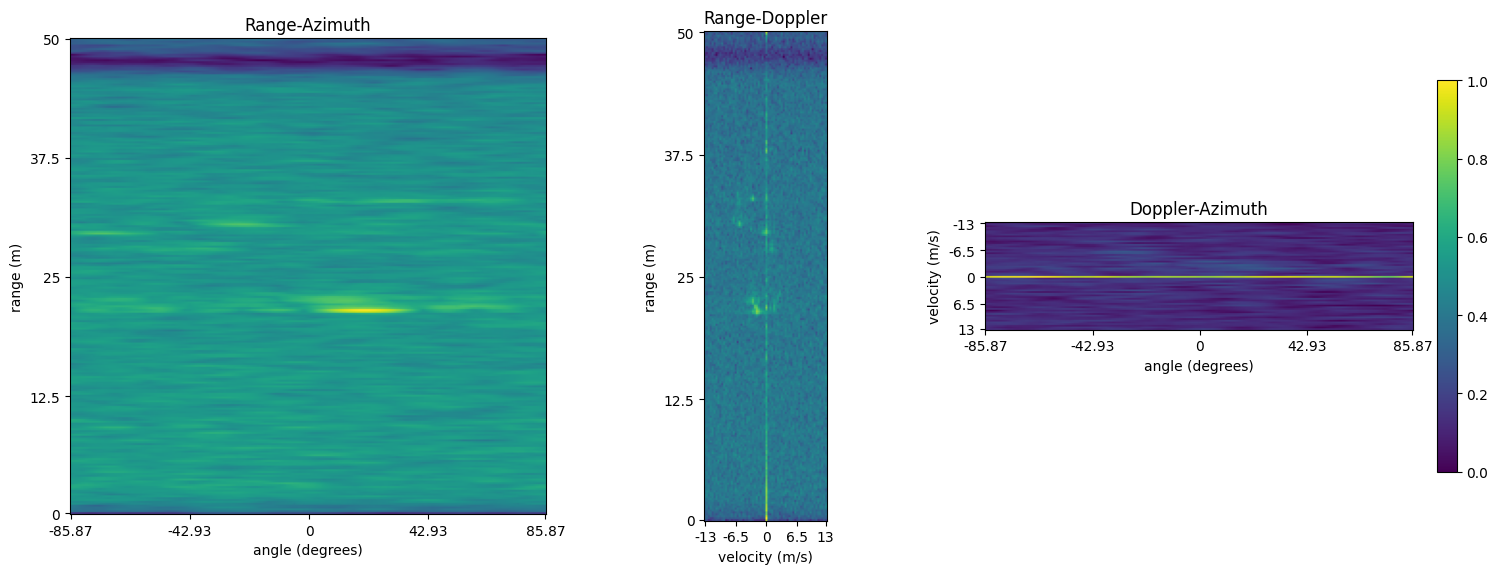

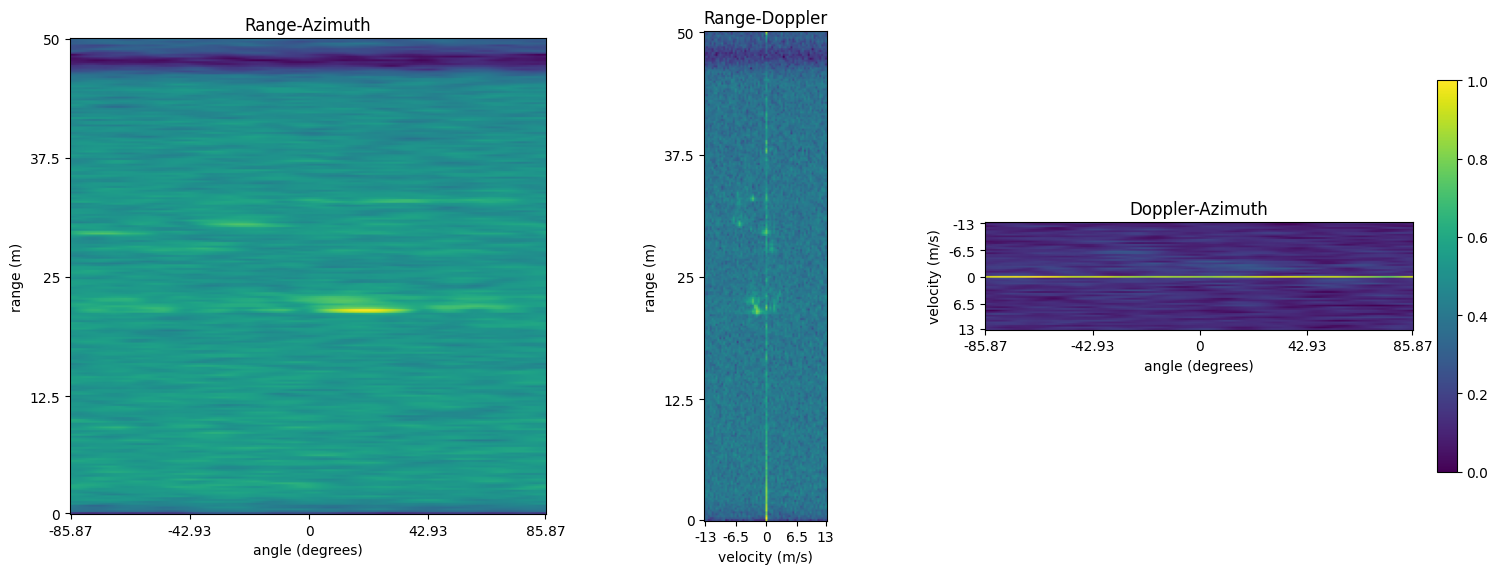

Reconstruction error: 0.00547005794942379
False


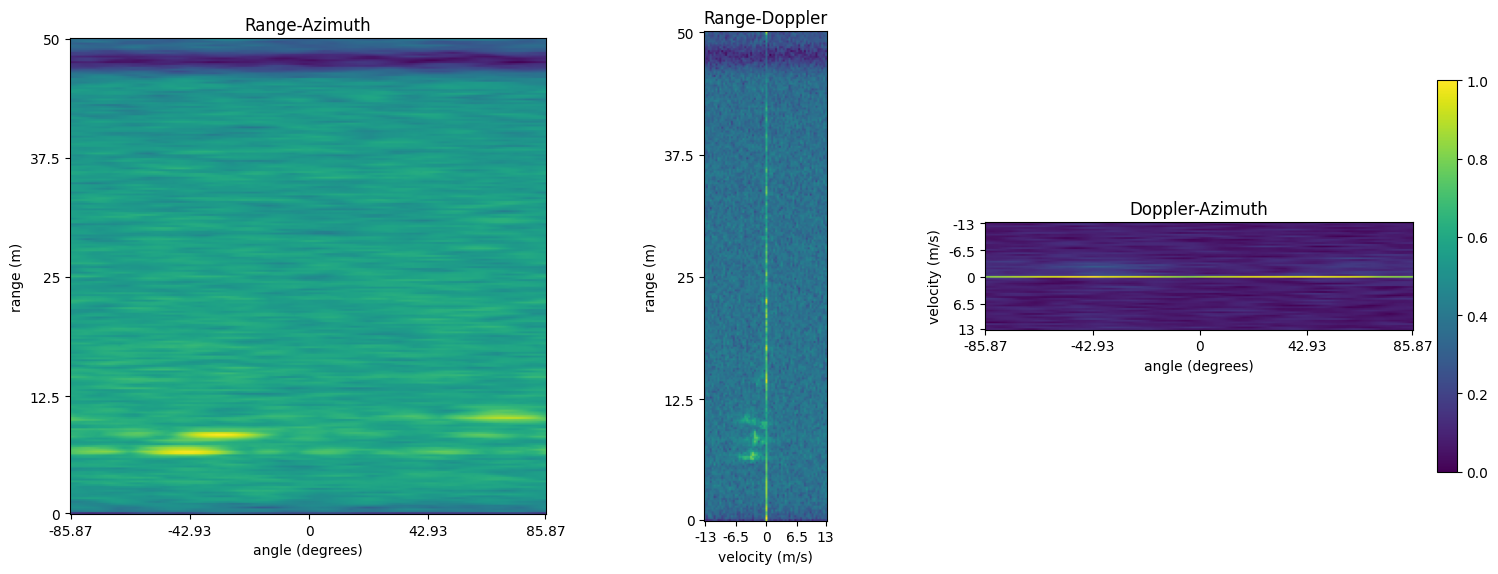

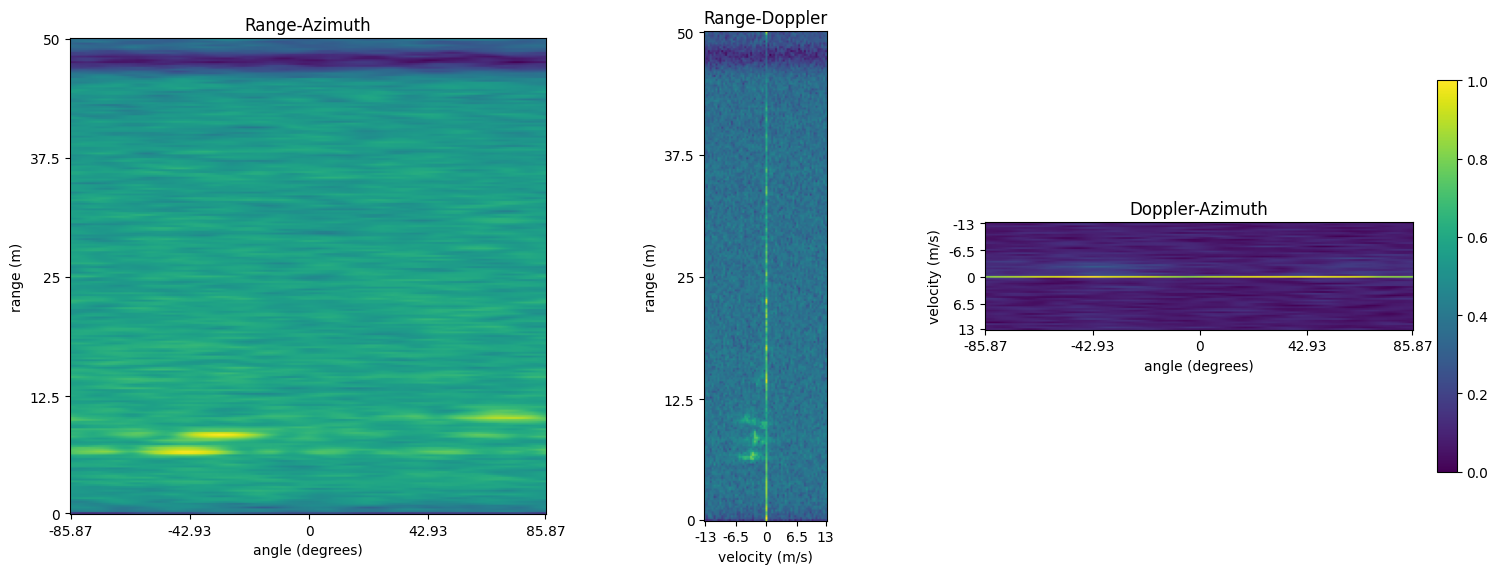

Reconstruction error: 0.007826042361557484
False


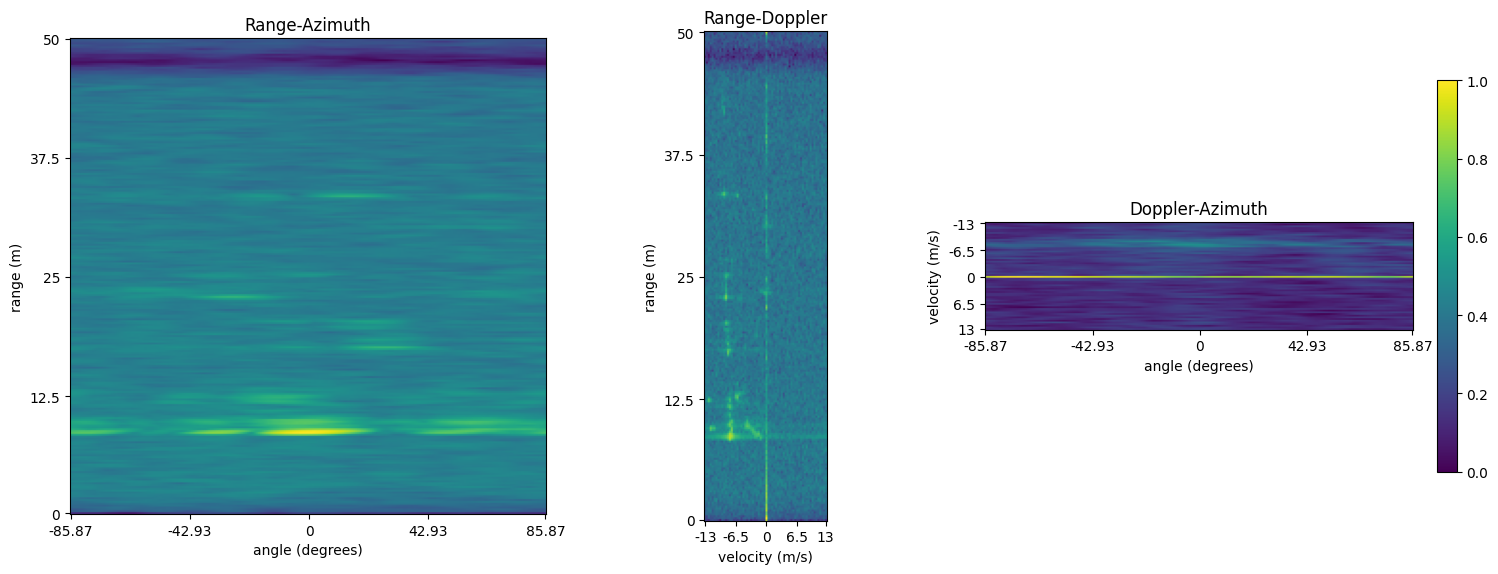

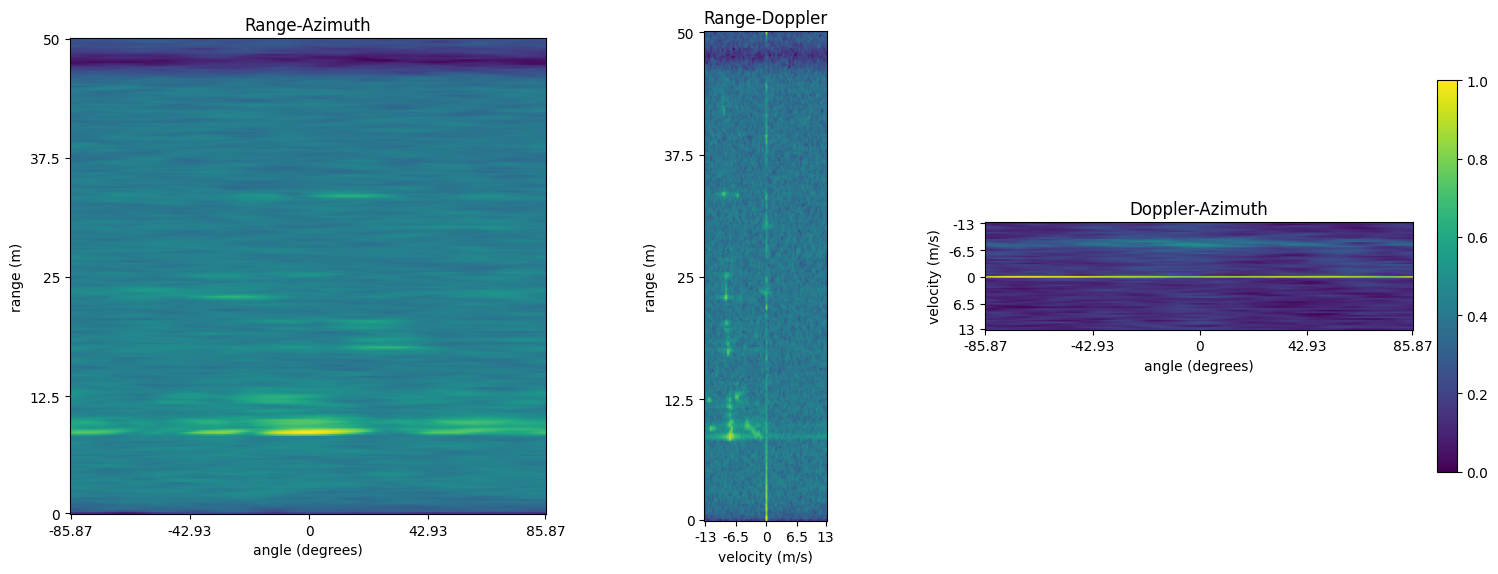

In [ ]:
import data_utils as du
from sklearn.decomposition import PCA

for index in range(len(sequences_all)):
    if index > 5:
        break
    # RD
    # RD_data = du.readRAD(sequences_all[index])
    # RD_data_padded = np.concatenate([RD_data, np.zeros((RD_data.shape[0], RD_data.shape[1], 256-8))], axis=-1)
    # FFT_data = np.fft.fft(RD_data_padded, n=256, axis=-1)

    RAD_data = du.readRAD(RAD_sequences_all[index]).transpose(0, 2, 1)
    RAD_data = du.preprocess_data(RAD_data)
    # RAD_data = (RAD_data - mean_log) / std_log
    RAD_data = du.normalize_data(RAD_data)

    # 将数据展开为 2D 矩阵以便应用 PCA
    data_2d = RAD_data.reshape(-1, RAD_data.shape[2])  # shape = (256*64, 256)

    # 使用 PCA 将 256 维降到 A_target_channel 维
    A_target_channel = 32

    pca = PCA(n_components=A_target_channel)
    reduced_data = pca.fit_transform(data_2d)  # shape = (256*64, 8)
    # 将降维后的数据恢复为 [256, 64, 8] 进行保存
    reduced_data_3d = reduced_data.reshape(256, 64, A_target_channel)

####################### 恢复数据 #######################
    reduced_data_2d = reduced_data_3d.reshape(-1, A_target_channel)
    # 使用 PCA 的逆变换将数据从 8 维恢复到 256 维
    reconstructed_data_2d = pca.inverse_transform(reduced_data_2d)  # shape = (256*64, 256)
    reconstructed_data_3d = reconstructed_data_2d.reshape(256, 64, 256)

    # 再归一化一次会降低精度，但也没降太多，A_target_channel越大，影响越小，要再归一化吗
    reconstructed_data_3d = du.normalize_data(reconstructed_data_3d)

    # 验证恢复的 reconstructed_data_3d 是否接近原始数据
    # error = np.abs((reconstructed_data_3d - RAD_data)/(RAD_data + 1e-6)).mean()
    # error = np.abs((reconstructed_data_3d - du.normalize_data(RAD_data))).mean()
    error = np.abs((reconstructed_data_3d - RAD_data)).mean()
    print(f'Reconstruction error: {error}')

    print(np.allclose(RAD_data, reconstructed_data_3d, atol=1e-4))

    du.plot_RAD(RAD_data.transpose(0, 2, 1), raw=True)
    du.plot_RAD(reconstructed_data_3d.transpose(0, 2, 1), raw=True)

    